In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import tempfile
import subprocess
from datetime import datetime
import time
import threading

from concurrent.futures import ProcessPoolExecutor
from collections.abc import Mapping

from IPython.display import Image
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
sns.set(rc={'figure.figsize': (16, 9), 'figure.dpi' : 100})

import nevergrad as ng
from SALib.sample import saltelli
from SALib.analyze import sobol
import geotopy as gtp
import psutil

In [3]:
# Defaults

# System settings
systmpfs = '/tmp'

# SA/Optimizer settings
num_workers = 2
budget = 32
SASampleN = 2
algorithm = 'OnePlusOne'
timeout = 30
monitor_interval = 2
target = 'soil_moisture_content_50'
problem_parameters = {"NVanGenuchten": [1.15, 2.0, 1.5, "gaussian"],
                      "AlphaVanGenuchten": [0.0005, 0.008, 0.002, "logarithmic"],
                      "ThetaSat": [0.4, 0.7, 0.5, "gaussian"],
                      "ThetaRes": [0.05, 0.3, 0.1, 'gaussian'],
                      "NormalHydrConductivity": [0.0001, 1.0, 0.01, "logarithmic"]}

In [4]:
# Parameters
systmpfs = "/dev/shm"
num_workers = 32
budget = 2048
SASampleN = 128
algorithm = "TwoPointsDE"
timeout = 60
monitor_interval = 10
target = "soil_moisture_content_50"
params = {
    "NVanGenuchten": [1.15, 2, 1.5, "gaussian"],
    "AlphaVanGenuchten": [0.0005, 0.008, 0.002, "logarithmic"],
    "ThetaSat": [0.4, 0.7, 0.5, "gaussian"],
    "ThetaRes": [0.05, 0.3, 0.1, "gaussian"],
    "NormalHydrConductivity": [0.0001, 1, 0.01, "logarithmic"],
}


# High-Performance Derivative-Free Optimization for the GE🌍top Model Calibration

### Stefano Campanella

#### Giacomo Bertoldi, Alberto Sartori, Emanuele Cordano

## GEOtop Calibration

GEOtop is a physical model that simulates the heat and water budgets at and below the soil surface. 

Some inputs are unknown/uncertain: find the values such that the ouputs better reproduce the experimental data.

Case study: LTSER sites in Val di Mazia, Alto Adige

## Challenges

1. Many parameters 
2. No good prior
3. Time consuming simulations

<b class=fragment>Parallel Derivative-free heuristic algorithms are the only option</b>

Some points to keep in mind:

* Community of scientists, not HPC experts nor programmers
* Wide range of use cases and applications
* Calibration is CPU bounded
* For these algorithms, <span class="fragment highlight-red">scaling can be a tricky subject</span>

Consider genetic algorithms/PSO.

<span class=fragment>Increasing the number of phenotypes/particles increases the coverage of the parameters space in each generation/iteration, but the principle of operation of these algorithms lies in the correlation between one generation/iteration and the next.</span>

<span class=fragment>Hence, scaling must take into account that cutting the time to solution by increasing the number of processing units and decreasing the number of iterations can lead to worse results.</span>

## The Goals

1. Write a reusable calibration tool, with a simple yet general enough interface
2. Make it easily deployable on HPC systems
3. Perform the optimization and analysis on the case study
4. Benchmark algorithms, objective functions, and hyperparameters

## Constraints

1. 1D simulations
2. Only scalar parameters (however, the framework allows more complex scenarios) 
3. No multi-objective (multiple targets must be squashed into a single one)

## Approach/Design Choices

* Python: simple language, good tooling e wide adoption in scientific computing community.
* Do not reinvent the wheel (use standard libraries as much as possible, otherwise third party libraries).
* Modularity, encapsulation and referential transparency.
* Emphasis on documentation and reproducibility.

## What has been done

<ol>
    <li class=fragment>Preliminary analysis of the case study and visualization</li>
    <li class=fragment><b>GEOtoPy</b>: A wrapper based on IO and keywords</li>
    <li class=fragment>Prototype of calibration with Nevergrad and SA with SALib</li>
    <li class=fragment>Deployment on Ulysses, now moving to VSC-4</li>
</ol>

## GEOtop IO Scheme

GEOtop works on text files, both for input and output.

The main one is `geotop.inpts` and contains settings and comments, other CSV data files may be provided.

Comments begin with a `!`, settings match `<keyword> = <value>`.

The values can be booleans, numbers, arrays or strings. 

Keyword are hardwired in GEOtop source code and have definite type.

## GEOtoPy

GEOtoPy exports the base, abstract class `GEOtop`, which can be subclassed to solve particular use cases.

Object of this class can parse, store and print the settings contained in `geotop.inpts`.

They can also evaluate the model _without side effects_.

## GEOtoPy Evaluation Model

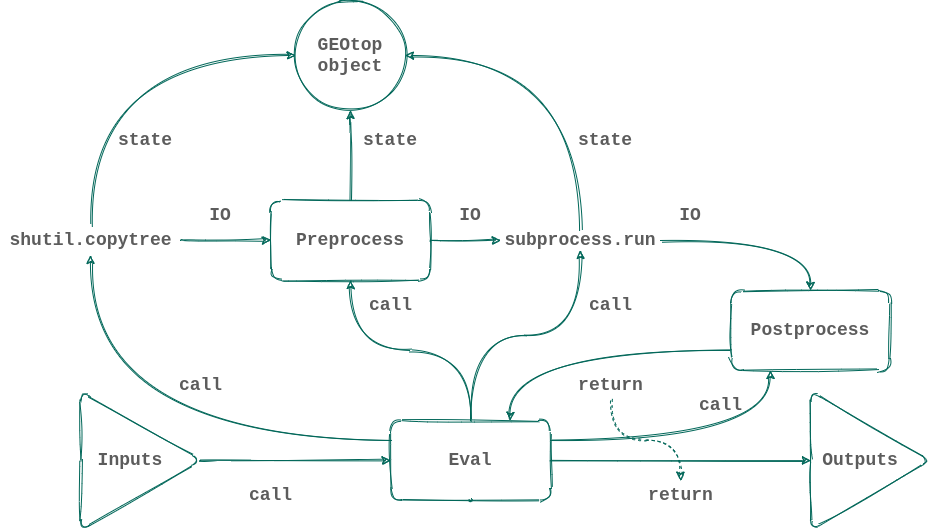

In [5]:
Image(filename="data/assets/geotopy.png")

In [6]:
class GEOtopExampleRun(gtp.GEOtop):

    def preprocess(self, working_dir, *args, **kwargs):
        
        settings = {**self, **kwargs}
        
        inpts_src_path = os.path.join(self.inputs_dir, 'geotop.inpts')
        inpts_dest_path = os.path.join(working_dir, 'geotop.inpts')
        
        with open(inpts_src_path, 'r') as inpts_src, open(inpts_dest_path, 'w') as inpts_dest:
            inpts_dest.write(f"! GEOtop input file written by GEOtoPy {datetime.now().strftime('%x %X')}\n")
            while line := inpts_src.readline():
                if gtp._comment_re.match(line):
                    inpts_dest.write(line)
                else:
                    try:
                        key, value = gtp.read_setting(line)
                        
                        if key in settings and value != settings[key]:
                            inpts_dest.write(f"! GEOtoPy: {key} overwritten, was {value}\n")
                            line = gtp.print_setting(key, settings[key])
                        else:
                            line = gtp.print_setting(key, value)
                        
                        inpts_dest.write(line)
                        del settings[key]
                    
                    except ValueError as err:
                        inpts_dest.write(f"! GEOtoPy: {err}\n")
                        inpts_dest.write(line)
            
            if settings:
                inpts_dest.write("\n! Settings added by GEOtoPy\n")
                for key, value in settings.items():
                    try:
                        line = gtp.print_setting(key, value)
                        inpts_dest.write(line)
                    except ValueError as err:
                        inpts_dest.write(f"! GEOtoPy: {err}\n")
                        inpts_dest.write(f"{key} = {value}\n")
                            
        
    def postprocess(self, working_dir):
        
        liq_path = os.path.join(working_dir, 'theta_liq.txt')
        liq = pd.read_csv(liq_path, 
                          na_values=['-9999'],
                          usecols=[0, 6, 7], 
                          skiprows=1,
                          header=0, 
                          names=['datetime', 'soil_moisture_content_50', 'soil_moisture_content_200'],
                          parse_dates=True, 
                          infer_datetime_format=True,
                          index_col=0)
        
        ice_path = os.path.join(working_dir, 'theta_ice.txt')
        ice = pd.read_csv(ice_path, 
                          na_values=['-9999'], 
                          usecols=[0, 6, 7], 
                          skiprows=1,
                          header=0, 
                          names=['datetime', 'soil_moisture_content_50', 'soil_moisture_content_200'],
                          parse_dates=True, 
                          infer_datetime_format=True,
                          index_col=0)
        
        sim = ice + liq
        
        return sim

In [7]:
class observations(Mapping):
    
    def __init__(self, path):
        
        self.data = pd.read_csv(path, 
                                na_values=['-9999'], 
                                parse_dates=True, 
                                infer_datetime_format=True,
                                index_col=0)
        
        self.data.index.rename('datetime', inplace=True)
        
        self.squared_mean = (self.data * self.data).mean()
        
    def __getitem__(self, key):
        
        return self.data[key]

    def __len__(self):
        
        return len(self.data)

    def __iter__(self):
        
        return iter(self.data)

    def compare(self, target, simulation, periods=None, name=None, unit=None, rel=False):

        if not periods:
            periods = {'Daily': 'D', 'Weekly': 'W', 'Monthly': 'M'}

        fig, axes = plt.subplots(ncols=3, 
                                 nrows=len(periods), 
                                 constrained_layout=True)

        if name:
            fig.suptitle(name)

        for i, (Tstr, T) in enumerate(periods.items()):
            comp_plot, diff_plot, hist_plot = axes[i, :]
            
            obs_resampled = self[target].resample(T).mean()
            sim_resampled = simulation[target].resample(T).mean()

            err = obs_resampled - sim_resampled        
            if rel:
                err = err / obs_resampled.abs()

            data = pd.DataFrame({'Observations': obs_resampled, 'Simulation': sim_resampled})
            sns.lineplot(data=data, ax=comp_plot)
            comp_plot.set_title(Tstr)
            comp_plot.set_xlabel("")
            if unit:
                comp_plot.set_ylabel(f"[{unit}]")

            sns.lineplot(data=err, ax=diff_plot)
            plt.setp(diff_plot.get_xticklabels(), rotation=20)
            if rel:
                diff_plot.set_ylabel("Relative error")
                diff_plot.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
            elif unit:
                diff_plot.set_ylabel(f"Error [{unit}]")
            else:
                diff_plot.set_ylabel("Error")

            sns.distplot(err, rug=True, vertical=True, hist=True, ax=hist_plot)
            y1, y2 = diff_plot.get_ylim()
            hist_plot.set_ylim(y1,y2)
            hist_plot.set_yticklabels([])
            hist_plot.set_ylabel("")
        
        return fig
    
    def metric(self, target, simulation):

        diff = (self[target] - simulation[target])
        diff_squared = diff * diff

        return np.sqrt(diff_squared.mean() / self.squared_mean[target])

In [8]:
class monitor:
    def __init__(self, interval):
        self.datetime = []
        self.cpu_usage = []
        self.memory_usage = []
        self.interval = interval
        self.running = False
        
        self.thread = threading.Thread(target=self.run, args=())
        self.thread.daemon = True

    def sample(self):
        self.datetime.append(datetime.now())
        self.cpu_usage.append(psutil.cpu_percent())
        self.memory_usage.append(psutil.virtual_memory().percent)
        
    def run(self):
        while self.running:
            self.sample()
            time.sleep(self.interval)
    
    def start(self):
        self.running = True
        self.thread.start()
        
    def stop(self):
        self.running = False
        self.thread.join()

In [9]:
stats = monitor(monitor_interval)
stats.start()

In [10]:
model = GEOtopExampleRun('data/inputs/run',
                         exe='../../geotop/build/geotop',
                         run_args={'check': True, 
                                   'capture_output': True, 
                                   'timeout': timeout})

obs = observations('data/inputs/obs.csv')

Before optimization loss is 0.20772106291136797


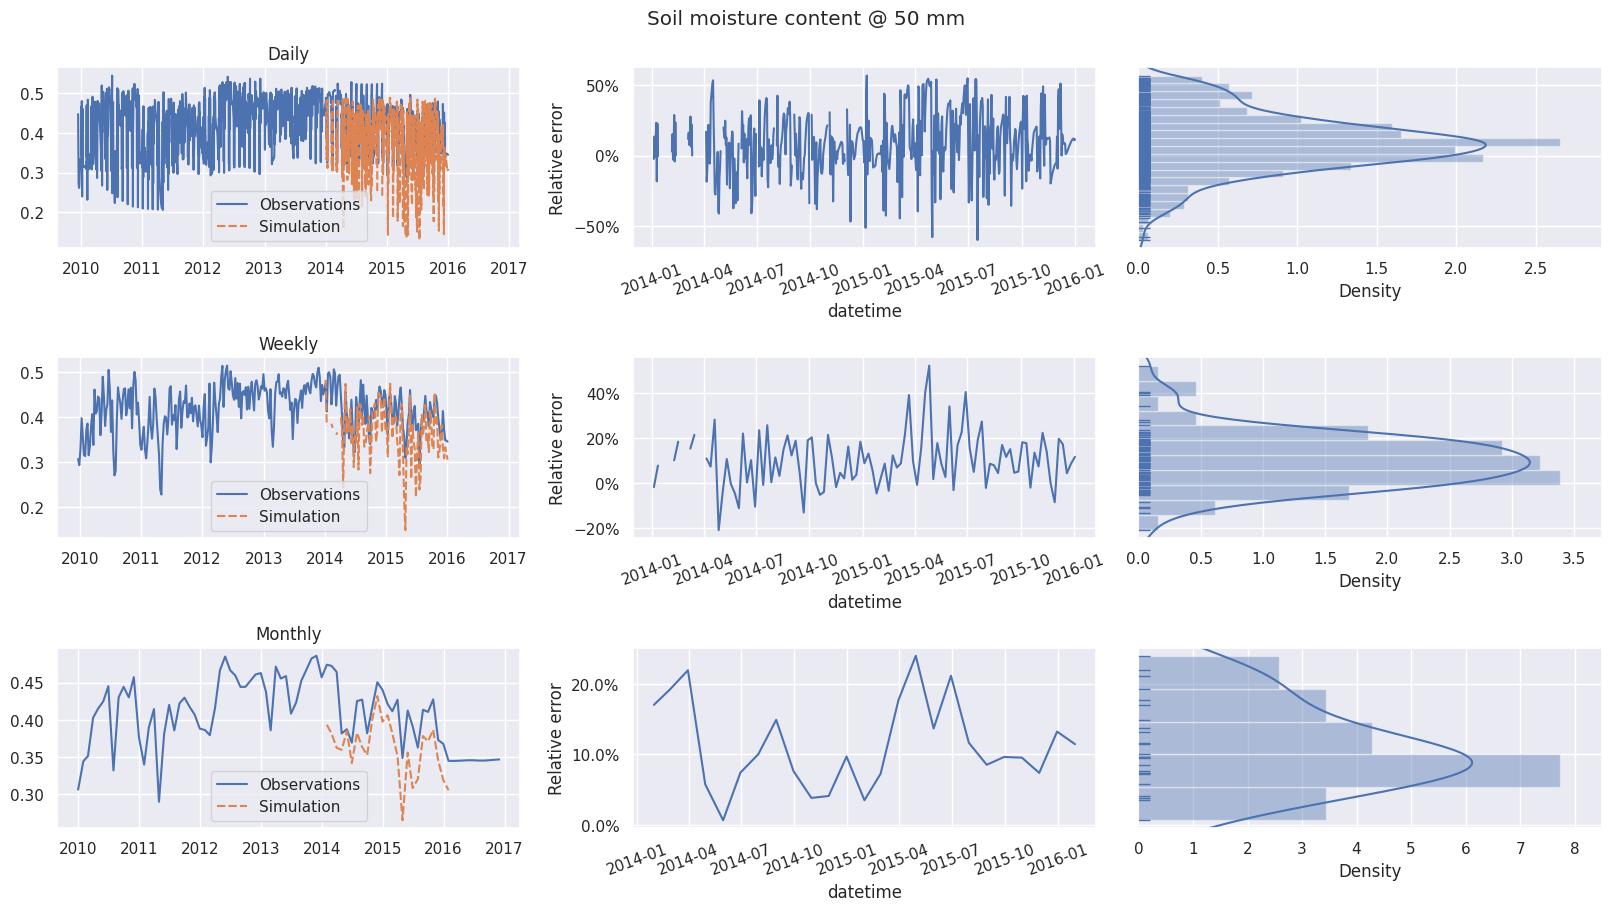

In [11]:
with tempfile.TemporaryDirectory(dir=systmpfs) as tmpdir:
    sim = model.eval(tmpdir)
    print(f"Before optimization loss is {obs.metric(target, sim)}")
    fig = obs.compare(target, sim, name="Soil moisture content @ 50 mm", rel=True)

## Example of Sensitivity Analysis

Right now, we are using the loss $\frac{\langle \left(y_\text{obs} - y_\text{sim} \right)^2 \rangle}{\langle y_\text{obs}^2 \rangle}$

In [12]:
def loss_function(*args, **kwargs): 
        
    with tempfile.TemporaryDirectory(dir=systmpfs) as tmpdir:
        try:
            sim = model.eval(tmpdir, *args, **kwargs)
        except subprocess.CalledProcessError:
            return np.nan
        except subprocess.TimeoutExpired:
            return np.nan

    return obs.metric(target, sim) # < (y_obs - y_sim)^2 > / < y_obs^2  >

In [13]:
def loss_SA_wrapper(xs):
    settings = {key: value for (key, value) in zip(problem_parameters, xs)}
    return loss_function(**settings)

problem = {'num_vars': len(problem_parameters),
           'names': [names for names in problem_parameters],
           'bounds': [(a, b) for a, b, _, _ in problem_parameters.values()]}

samples = saltelli.sample(problem, SASampleN, calc_second_order=False)

executor = ProcessPoolExecutor(max_workers=num_workers)
losses = np.fromiter(executor.map(loss_SA_wrapper, samples), dtype=float)

In [14]:
SA = sobol.analyze(problem, losses, calc_second_order=False);
SA_df = pd.DataFrame(SA, index=problem['names']);
SA_df.sort_values('S1', key=np.abs, ascending=False)

S1   S1_conf        ST   ST_conf
ThetaRes                0.325572  0.174019  0.507979  0.130865
NVanGenuchten           0.285329  0.136472  0.420579  0.154895
ThetaSat                0.031477  0.071975  0.082492  0.021626
NormalHydrConductivity  0.005119  0.039413  0.027784  0.013996
AlphaVanGenuchten      -0.002128  0.016329  0.003886  0.001434

## Example of Calibration

In [15]:
parameter_type = {'gaussian': ng.p.Scalar, 'logarithmic': ng.p.Log}

optimization_parameters = {name: parameter_type[distribution](init=x0, lower=a, upper=b) 
                           for name, (a, b, x0, distribution) in problem_parameters.items()}

optimizer = ng.optimizers.registry[algorithm](parametrization=ng.p.Instrumentation(**optimization_parameters), 
                                              budget=budget, 
                                              num_workers=num_workers)

logfile = tempfile.NamedTemporaryFile(dir=systmpfs)
logger = ng.callbacks.ParametersLogger(logfile.name)
optimizer.register_callback("tell",  logger)

In [16]:
for sample, loss in zip(samples, losses):
    optimizer.suggest(**dict(zip(problem_parameters, sample)))
    candidate = optimizer.ask()
    optimizer.tell(candidate, loss)
    
with ProcessPoolExecutor(max_workers=optimizer.num_workers) as executor:
    recommendation = optimizer.minimize(loss_function, 
                                        executor=executor, 
                                        batch_mode=False)

In [17]:
optim_df = pd.DataFrame.from_dict(problem_parameters, orient='index', columns=['lower', 'upper', 'suggested', 'distribution'])
optim_df['best'] = pd.Series(recommendation.kwargs)
optim_df

lower  upper  suggested distribution      best
NVanGenuchten           1.1500  2.000      1.500     gaussian  1.439463
AlphaVanGenuchten       0.0005  0.008      0.002  logarithmic  0.000500
ThetaSat                0.4000  0.700      0.500     gaussian  0.452529
ThetaRes                0.0500  0.300      0.100     gaussian  0.178675
NormalHydrConductivity  0.0001  1.000      0.010  logarithmic  0.000100

After optimization loss is 0.10622133697943444


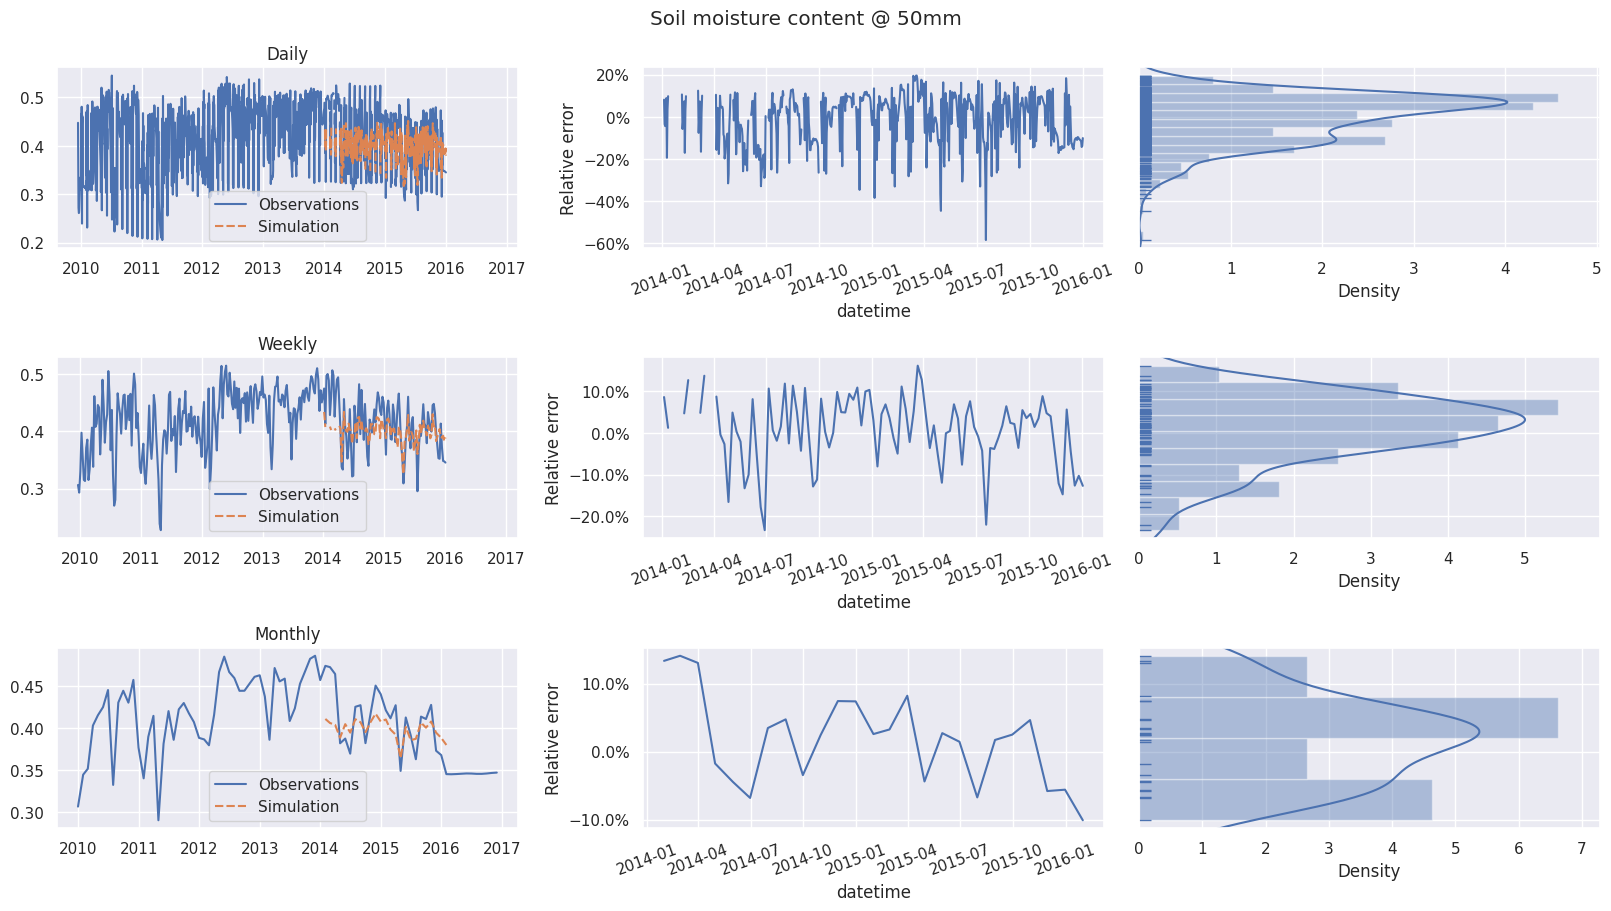

In [18]:
with tempfile.TemporaryDirectory() as tmpdir:
    print(f"After optimization loss is {recommendation.loss}")
    sim = model.eval(tmpdir, **recommendation.kwargs)
    fig = obs.compare(target, sim, name=f"Soil moisture content @ 50mm", rel=True)

## Parallel Coordinates Visualization with HiPlot

In [19]:
logger.load()
experiment = logger.to_hiplot_experiment()
experiment.display()

<IPython.core.display.Javascript object>

## CPU and Memory Usage

In [20]:
stats.stop()
stats_df = pd.DataFrame({'cpu': stats.cpu_usage, 'memory': stats.memory_usage}, index=stats.datetime)

<AxesSubplot:title={'center':'Resource Monitor'}, xlabel='Time', ylabel='Usage [%]'>

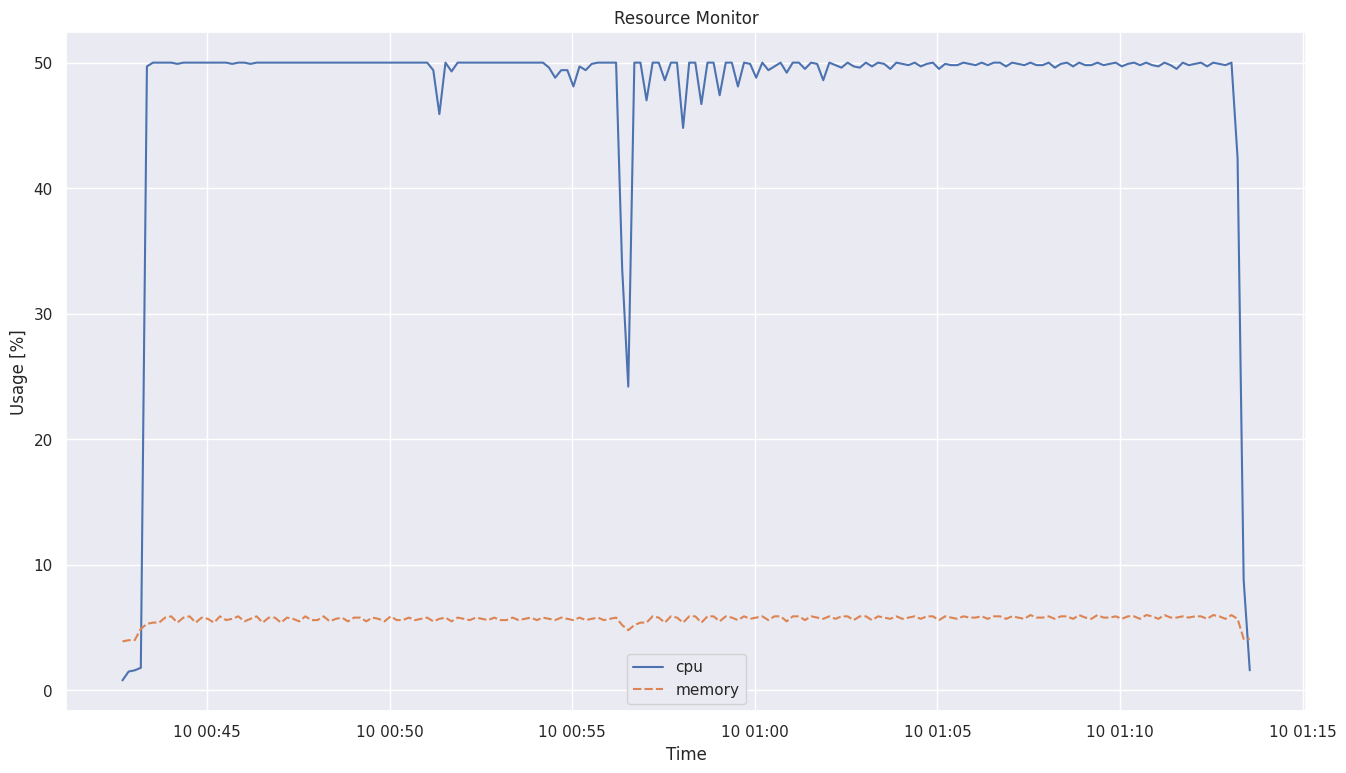

In [21]:
fig = plt.figure()
axes = fig.add_subplot()
axes.set_title('Resource Monitor')
axes.set_xlabel('Time')
axes.set_ylabel('Usage [%]')
sns.lineplot(data=stats_df, ax=axes)

## Deployment

1. SPACK
2. PyPi
3. Pipenv
4. Papermill

## To Do

1. Assemble the calibration package
2. Benchmarks

## Further developments

1. Ray Tune + Nevergrad (multinode)?
2. Multinode SA with Ray?
3. Inoculate information from SA into optimizer?
4. IO optimizations?
5. BFGS after global optimization?
6. Parameters clustering?

## Acknowledgments

The research reported in this work will be supported by OGS, Eurac and CINECA under HPC-TRES program award number 2019-33